MOCPy introduction
--------------------

MOCPy is a python library for creating, manipulate and parse MOCs (Multi-Order Coverage maps).
A MOC describes any arbitrary region on the sky. MOCs can be used to:

- Represent the spatial footprint of a catalog (source and/or image survey).
- Compare the footprints, perform fast intersections, unions, differences.
- Filter an astropy table by discarding all the sources that do not lie in the MOC region.

MOCPy's code can be found on GitHub: https://github.com/cds-astro/mocpy
You can install it: `pip install mocpy`

MOCPy's documentation: https://cds-astro.github.io/mocpy/

In [1]:
import mocpy
from mocpy import WCS

import matplotlib.pyplot as plt

from regions import CircleSkyRegion
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astroquery.cds import cds
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad

from ipyaladin import Aladin
from ipywidgets import Layout, Box, widgets

mocpy.__version__

'0.13.0'

## Use astroquery.cds to get spatial footprints (MOCs)
----------------------------------------------------------------------

MOCs can be retrieved from ``astroquery.cds``. ``astroquery.cds`` offers a Python access API  to the MOCServer that stores ~20000 metadata and MOCs of Vizier catalogues and ~500 metadata and MOCs of HiPS image surveys.

``astroquery.cds`` documentation https://astroquery.readthedocs.io/en/latest/cds/cds.html#getting-started

-----------
Let's retrieve:

- The MOC representing the footprint of all the HST combined surveys (see the astroquery.cds documentation, an example is given about that) at the order 8 (i.e. the precision of the MOC, ~13 arcmin)
- The MOC representing the footprint of SDSS9: ID='CDS/P/SDSS9/color'

In [2]:
# HST MOC footprint
# -----------------
# We want to retrieve all the HST surveys i.e. the HST surveys covering any region of the sky.
allsky = CircleSkyRegion(SkyCoord(0, 0, unit="deg"), Angle(180, unit="deg"))
hst_moc = cds.query_region(
    region=allsky,
    # We want a MOCpy object instead of an astropy table
    return_moc=True,
    # The order of the MOC
    max_norder=8,
    # Expression on the ID meta-data
    meta_data="ID=*HST*",
)

# SDSS9
# -----
sdss_moc = cds.find_datasets(meta_data="ID=CDS/P/SDSS9/color", return_moc=True)

# GALEX
# -----
# galex = cds.find_datasets(meta_data="ID=CDS/P/GALEXGR6/AIS/color", return_moc=True)

In [3]:
type(sdss_moc)

mocpy.moc.moc.MOC

## Manipulate MOCs using MOCPy
---------------------------------------------

``astroquery.cds`` returns mocpy.MOC typed objects. Use MOCPy (see the API of the mocpy.MOC class https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC) to manipulate them, for example you could:

- Compute their intersection/union
- Serialize them to FITS/json, save them to FITS files
- Filter an astropy table to keep only the sources being on a MOC (the intersection between sdss and the hst surveys).

In [4]:
%%time
sdss_and_hst_moc = sdss_moc.intersection(hst_moc)
sdss_moc.serialize(format="fits")
sdss_moc.save("sdss_moc.fits", format="fits", overwrite=True)

CPU times: user 8.81 ms, sys: 6.02 ms, total: 14.8 ms
Wall time: 15.2 ms


## Plot a MOC using matplotlib
----------------------------------------

Let's see how to plot a MOC using matplotlib.
There is an example of that on the MOCPy's documentation: https://cds-astro.github.io/mocpy/examples/examples.html#loading-and-plotting-the-moc-of-sdss

----------
We use ``matplotlib`` and``MOCPy`` to draw the MOCs of HST and SDSS that we downloaded from `astroquery.cds`.

MOCPy offers an interface to create a WCS:

- centered around a SkyCoord position
- with a specific field of view 
- and a projection (follows this link to see all the projection supported : https://docs.astropy.org/en/stable/wcs/#supported-projections)

MOCPy offers 2 methods taking a ``matplotlib.axe.Axe`` and drawing into it either:

- the full area of the MOC (``mocpy.MOC.fill``)
- only its perimeter (``mocpy.MOC.border``)

These methods accept additional stylistic kwargs defined by ``matplotlib``: https://matplotlib.org/api/_as_gen/matplotlib.patches.PathPatch.html#matplotlib.patches.PathPatch

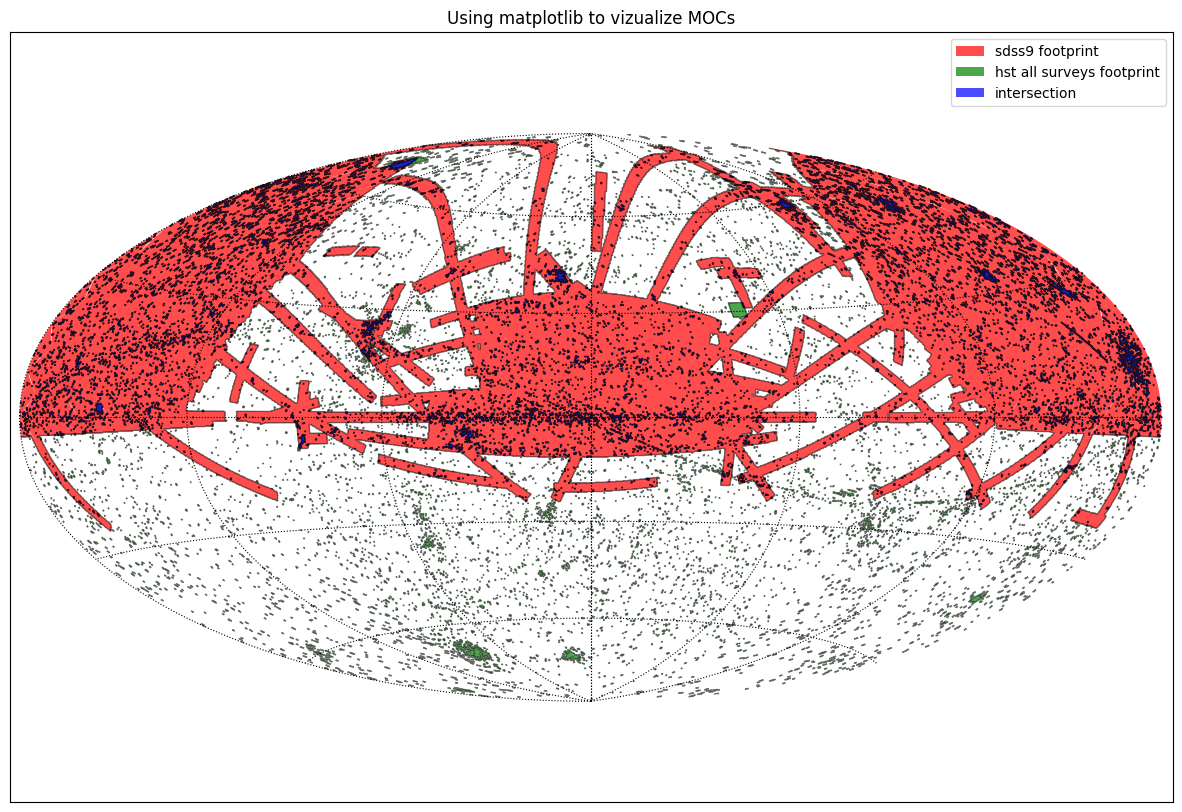

In [5]:
fig = plt.figure(figsize=(15, 10))

with WCS(
    fig,
    fov=220 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    # Create a matplotlib axe and give it a astropy.wcs.WCS-like object
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    # Fill the SDSS MOC in red with an opacity of 70%
    sdss_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="r",
        facecolor="r",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="sdss9 footprint",
    )
    # Draw its perimeter in black
    sdss_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

    # Fill the HST surveys MOC in green with an opacity of 70%
    hst_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="g",
        facecolor="g",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="hst all surveys footprint",
    )
    # Draw its perimeter in black
    hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

    # Fill the intersection MOC in blue
    sdss_and_hst_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="b",
        facecolor="b",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="intersection",
    )
    # Draw its perimeter in black
    sdss_and_hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

# Usual matplotlib calls
plt.title("Using matplotlib to vizualize MOCs")
plt.xlabel("ra")
plt.ylabel("dec")
plt.legend()
plt.grid(color="black", linestyle="dotted")
plt.show()
plt.close()

## Filter an astropy.Table by a MOC
---------------------------------------------
 
1. Retrieve a catalog table from Vizier (e.g. II/50). Add the columns '_RAJ2000' and '_DEJ2000' to the outputs. MOCPy needs the positions for filtering the table.
2. Filter the table to get only the sources that lie into intersection MOC.

In [6]:
viz = Vizier(columns=["*", "_RAJ2000", "_DEJ2000"])
viz.ROW_LIMIT = -1
# Photometric standard stars (tables II and IV of paper)
tables = viz.get_catalogs("II/50")

print(tables)
table = tables[0]
table

TableList with 1 tables:
	'0:II/50/ubv' with 20 column(s) and 2036 row(s) 


_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,str1,float32,str1,float32,float32,float32,str1,float32,float32,float32,str1,float32,str1,str23,str6,float64,float64
1.3339206,-5.7076183,28,,4.615,,0.007,5.20,1.040,,0.007,5.50,0.89,,2.50,,,Simbad,1.33392,-5.70762
2.3526750,-45.7474261,496,,3.875,,0.005,2.50,1.020,,0.010,2.70,0.86,,1.00,C,,Simbad,2.35267,-45.74743
3.6600664,-18.9328656,1038,,4.430,),0.018,3.50,1.655,,0.006,3.70,2.00,:,3.00,*,,Simbad,3.66007,-18.93287
4.8569769,-8.8239214,1522,,3.550,),0.016,6.20,1.220,),0.014,6.20,1.20,:,4.50,*,,Simbad,4.85698,-8.82392
5.0177506,-64.8747906,1581,,4.220,,--,1.50,0.575,,--,1.50,0.01,,1.00,C,,Simbad,5.01775,-64.87479
6.4377994,-77.2542456,2151,,2.800,,0.006,2.50,0.625,,0.005,1.70,0.10,,1.00,C,,Simbad,6.43780,-77.25425
6.5710456,-42.3059814,2261,,2.395,,0.013,3.50,1.085,,0.004,3.20,0.89,,1.00,C,,Simbad,6.57105,-42.30598
6.5508408,-43.6798294,2262,,3.940,,0.013,2.50,0.170,,0.008,2.70,0.11,,1.00,C,,Simbad,6.55084,-43.67983


In [7]:
idx_inside = sdss_and_hst_moc.contains_lonlat(
    table["_RAJ2000"].T * u.deg,
    table["_DEJ2000"].T * u.deg,
)
sources_inside = table[idx_inside]
sources_inside

_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,str1,float32,str1,float32,float32,float32,str1,float32,float32,float32,str1,float32,str1,str23,str6,float64,float64
15.7358683,7.8901356,6186,,4.275,,0.012,3.50,0.965,,0.011,3.50,0.69,,2.00,,,Simbad,15.73587,7.89014
25.3578931,5.4876133,10380,,4.445,,0.008,4.70,1.365,,0.006,4.50,1.56,,3.50,,,Simbad,25.35789,5.48761
34.8366364,-2.9776425,14386,,--,),--,--,1.600,,--,0.70,--,,--,,,Simbad,34.83664,-2.97764
49.8404000,3.3701978,20630,,4.845,,0.011,9.70,0.680,,0.006,9.20,0.20,,5.75,,,Simbad,49.84040,3.37020
82.9827500,-7.3015369,36512,,4.615,,0.012,8.70,-0.260,,0.006,8.50,-1.07,,5.00,,,Simbad,82.98275,-7.30154
83.7541956,-6.0092700,36959,,5.665,,--,1.00,-0.220,,--,1.00,-0.91,,1.50,,,Simbad,83.75420,-6.00927
83.7611731,-6.0020269,36960,,4.785,,0.009,2.00,-0.245,,--,1.50,-1.01,,1.75,,,Simbad,83.76117,-6.00203
83.8465175,-4.8383578,37018,,4.590,,0.009,4.00,-0.200,,0.004,4.00,-0.93,,3.50,,,Simbad,83.84652,-4.83836


## Run Aladin-Lite inside a jupyter notebook: ipyaladin
-----------------------------------------------------------------------

Aladin-Lite can be embedded into a jupyter notebook: Follow the readme on GitHub for installing it: https://github.com/cds-astro/ipyaladin

In [8]:
aladin = Aladin()
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [9]:
aladin.target = "messier 51"
aladin.fov = 1
aladin.height = 600

In [10]:
aladin.coo_frame = "icrs"

Change the image survey, go to https://aladin.unistra.fr/hips/list (Part 1. HiPS sky maps) to test with different image surveys! A list of good HiPS I like for testing:
- P/2MASS/color
- P/PanSTARRS/DR1/color-z-zg-g
- P/SPITZER/color
- P/SDSS9/color
- P/GALEXGR6/AIS/color
- P/Mellinger/color

In [11]:
aladin.survey = "P/SDSS9/color"

Add a MOC in the aladin-lite view!

In [12]:
# First use MOCPy to serialize our MOC into the JSON format
moc_serialized_json = sdss_and_hst_moc.serialize("json")
aladin.add_moc_from_dict(
    moc_serialized_json,
    {"adaptativeDisplay": True, "color": "blue", "opacity": 0.3},
)

In [13]:
# Add astropy source tables to the aladin lite viewer
aladin.add_table(sources_inside)
aladin.add_table(table[~idx_inside])

In [14]:
# change the fov and target
aladin.target = "13 04 4.193 -03 34 13.54"
aladin.fov = 11

--------

Pass Python callback functions to Javascript event listeners
-----------

In [15]:
aladin = Aladin(target="M 1", fov=0.2)
aladin

Aladin(fov=0.2, layout=Layout(width='100%'), options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen',…

In [16]:
table = Simbad.query_region("M 1", radius=0.1 * u.deg)
aladin.add_table(table)
aladin.height = 600

In [17]:
def get_ra_dec_data(source):
    """Return the MainID, and coordinates of the clicked sources."""
    return [source["data"]["MAIN_ID"], source["ra"], source["dec"]]


def hover_source_callback(source):
    """Return data corresponding to the hovered sources."""
    return source["data"]


# When trigerred, the listeners on the js side of the application will send a
# json object whose parameter data
# will be used by the python functions
# (data is a litteral object on the js side, it will be converted as a
# dictionary object on the Python side)
aladin.add_listener("objectHovered", hover_source_callback)
aladin.add_listener("objectClicked", get_ra_dec_data)

----------

Advanced example
----------------------

Create a rectangular selection using ``ipywidgets`` and gives back the selected sources to the user

In [18]:
aladin = Aladin(layout=Layout(width="70%"), target="M 1", fov=0.2)

button = widgets.Button(description="Select")


def on_button_clicked(b):  # noqa: ARG001
    """Trigger the rectangular selection tool."""
    aladin.rectangular_selection()


button.on_click(on_button_clicked)
table_info = widgets.HTML(layout=Layout(height="auto", overflow="auto"))

box_layout = Layout(
    display="flex",
    flex_flow="row",
    align_items="stretch",
    width="100%",
    overflow="hidden",
    height="100vh",
    margin="-100px 0 0 0",
    padding="100px 0 0 0 ",
)
box = Box(children=[aladin, button, table_info], layout=box_layout)
box

Box(children=(Aladin(fov=0.2, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', '…

In [19]:
table = Simbad.query_region("M 1", radius=0.1 * u.deg)
aladin.add_table(table)


def process_result(sources):
    """Output an html table."""
    s = '<table border="1">'
    s += "<tr><th>MAIN_ID</th><th>RA</th><th>DEC</th></tr>"
    for source in sources:
        s += "<tr><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            source["data"]["MAIN_ID"],
            source["data"]["RA"],
            source["data"]["DEC"],
        )
    s += "</table>"
    table_info.value = s


aladin.add_listener("select", process_result)

-------

Useful links
-------------

More info about MOCs:

- It relies on the HEALPix tesselation of the sphere: paper link https://iopscience.iop.org/article/10.1086/427976/fulltext/
- HEALPix implementation in the cdshealpix (`pip install cdshealpix`) https://github.com/cds-astro/cds-healpix-python
- The IVOA reference paper about MOC: http://ivoa.net/documents/MOC/20190903/PR-MOC-1.1-20190903.pdf

Time-MOCs and recently Space-Time MOCs:

- ADASS 2019 presentation from Pierre Fernique: https://www.adass2019.nl/wp-content/uploads/adass-oral/O2-3-fernique-stmoc-behind-the-scene.pdf
- IVOA notebook about ST-MOCs in MOCPy: https://github.com/cds-astro/mocpy/blob/master/notebooks/Space%20%26%20Time%20coverages.ipynb